<a href="https://www.kaggle.com/code/faisalalbasu/spectrogram-windows-test?scriptVersionId=137966541" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
import random
import seaborn as sns
from matplotlib.colors import ListedColormap

# plt.style.use('seaborn')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# small sampled data
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample%20analysis.csv'

--2023-07-26 11:30:10--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample%20analysis.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17946 (18K) [text/plain]
Saving to: ‘sample analysis.csv’

sample analysis.csv 100%[===================>]  17.53K  --.-KB/s    in 0.001s  

2023-07-26 11:30:11 (11.8 MB/s) - ‘sample analysis.csv’ saved [17946/17946]



In [3]:
# small sample with diagnoses
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample_analysis_diagnoses.csv'

--2023-07-26 11:30:12--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample_analysis_diagnoses.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104 [text/plain]
Saving to: ‘sample_analysis_diagnoses.csv’

sample_analysis_dia 100%[===================>]     104  --.-KB/s    in 0s      

2023-07-26 11:30:12 (938 KB/s) - ‘sample_analysis_diagnoses.csv’ saved [104/104]



In [4]:
# full data for maximimum signals
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum.csv'

--2023-07-26 11:30:13--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2175039 (2.1M) [text/plain]
Saving to: ‘maximum.csv’

maximum.csv         100%[===================>]   2.07M  --.-KB/s    in 0.07s   

2023-07-26 11:30:14 (28.8 MB/s) - ‘maximum.csv’ saved [2175039/2175039]



In [5]:
# full data with diagnoses
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum_diagnoses.csv'

--2023-07-26 11:30:15--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum_diagnoses.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5623 (5.5K) [text/plain]
Saving to: ‘maximum_diagnoses.csv’

maximum_diagnoses.c 100%[===================>]   5.49K  --.-KB/s    in 0s      

2023-07-26 11:30:15 (50.7 MB/s) - ‘maximum_diagnoses.csv’ saved [5623/5623]



In [6]:
max_erg = pd.read_csv('/kaggle/working/maximum.csv', sep = ',', index_col = 'Time,ms')
max_erg.head()

,3,3.1,5,6,6.1,6.2,7,10,11,15,...,1880,1931,1961,1961.1,1962,1962.1,1963,1963.1,1964,1964.1
"Time,ms",,,,,,,,,,,,,,,,,,,,,
0.0,0.000004,-2.35,0.000013,-10.8,1.150000e-06,0.000003,-3.466499,-8.67,1.320000e-06,-3.10,...,0.000025,0.000029,-2.076184,-7.590125,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
0.5,0.000004,-2.47,0.000012,-11.1,9.600000e-07,0.000003,-3.523260,-9.02,1.120000e-06,-3.45,...,0.000025,0.000029,-2.106670,-7.468806,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
1.0,0.000004,-2.63,0.000012,-11.5,7.460000e-07,0.000002,-3.602958,-9.39,9.050000e-07,-3.83,...,0.000025,0.000028,-2.131098,-7.339658,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
1.5,0.000004,-2.80,0.000012,-11.9,5.060000e-07,0.000002,-3.705310,-9.79,6.810000e-07,-4.25,...,0.000025,0.000028,-2.149734,-7.204155,0.000002,0.000002,0.000022,0.000019,0.000016,0.00002
2.0,0.000003,-3.01,0.000012,-12.4,2.440000e-07,0.000001,-3.829635,-10.20,4.460000e-07,-4.70,...,0.000025,0.000027,-2.162955,-7.063886,0.000002,0.000002,0.000022,0.000019,0.000016,0.00002


In [7]:
diag_max_erg = pd.read_csv('/kaggle/working/maximum_diagnoses.csv', sep = ',')
diag_max_erg

,Unnamed: 0,3,3.1,5,6,6.1,6.2,7,10,11,...,1880,1931,1961,1961.1,1962,1962.1,1963,1963.1,1964,1964.1
0,Diagnosis,unhealthy,healthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,...,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy


In [8]:
diag_max_erg.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
data = pd.read_csv('/kaggle/working/sample analysis.csv', sep = ',', index_col='Time,ms')
data

,3,5,6,6.1,6.2,15,17,17.1
"Time,ms",,,,,,,,
0.0,-2.351363,0.000013,-10.800000,1.150000e-06,0.000003,-3.100000,1.470000e-06,0.000005
0.5,-2.473562,0.000012,-11.100000,9.600000e-07,0.000003,-3.450000,1.310000e-06,0.000005
1.0,-2.625094,0.000012,-11.500000,7.460000e-07,0.000002,-3.830000,1.130000e-06,0.000004
1.5,-2.804676,0.000012,-11.900000,5.060000e-07,0.000002,-4.250000,9.300000e-07,0.000004
2.0,-3.010519,0.000012,-12.400000,2.440000e-07,0.000001,-4.700000,7.250000e-07,0.000004
...,...,...,...,...,...,...,...,...
98.0,-2.117023,-0.000012,24.090590,3.810000e-06,0.000004,-8.207112,-8.300000e-06,-0.000011
98.5,-2.444991,-0.000013,23.955892,4.010000e-06,0.000004,-8.046144,-7.690000e-06,-0.000011
99.0,-2.729824,-0.000014,23.885146,4.220000e-06,0.000004,-7.833394,-7.080000e-06,-0.000011


In [10]:
diagdata = pd.read_csv('/kaggle/working/sample_analysis_diagnoses.csv', sep = ',')
diagdata

,Unnamed: 0,3,5,6,6.1,6.2,15,17,17.1
0,Diagnosis,healthy,unhealthy,unhealthy,unhealthy,unhealthy,healthy,healthy,healthy


In [11]:
diagdata.drop('Unnamed: 0', axis = 1, inplace = True)
diagdata

,3,5,6,6.1,6.2,15,17,17.1
0,healthy,unhealthy,unhealthy,unhealthy,unhealthy,healthy,healthy,healthy


In [12]:
NFFTS = [128, 64, 32, 16, 8, 4]
overlaps = [64, 32, 16, 8, 4, 2]
windows = ['hann', 'hamming', 'blackman', 'tukey', 'boxcar', 'bartlett', 'blackmanharris']

In [13]:
def plot_spectrogram(sig: str, nfft, noverlap, colormap):
    time_step = 0.005 # in seconds
    sample_freq = 1 / time_step
    sig = np.array(max_erg[sig])
    
    assert sig.ndim  == 1
    assert nfft <= len(sig)
    
#     window = np.blackman(nfft)
    window = signal.get_window('taylor', nfft)
    
    Sxx, freqs, bins, im = plt.specgram(sig, Fs = sample_freq, NFFT = nfft, noverlap = noverlap, cmap = colormap, window = window)
    plt.colorbar().set_label('Power')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    return Sxx

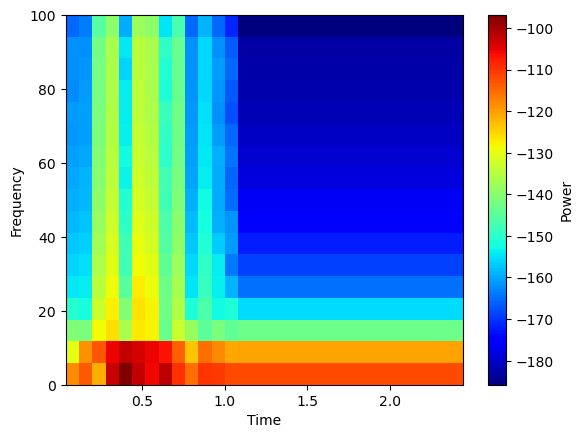

array([[1.49933643e-12, 4.64195954e-12, 6.98794380e-13, 5.41573993e-11,
        2.03111049e-10, 5.88213760e-11, 2.63860371e-11, 6.65596078e-11,
        1.08062548e-11, 2.87309508e-12, 1.02142523e-11, 9.40259499e-12,
        6.22456961e-12, 6.03334618e-12, 6.03334618e-12, 6.03334618e-12,
        6.03334618e-12, 6.03334618e-12, 6.03334618e-12, 6.03334618e-12,
        6.03334618e-12, 6.03334618e-12, 6.03334618e-12, 6.03334618e-12,
        6.03334618e-12, 6.03334618e-12, 6.03334618e-12, 6.03334618e-12,
        6.03334618e-12, 6.03334618e-12],
       [1.01432292e-13, 1.37030539e-12, 4.92147244e-12, 2.94152936e-11,
        5.68986144e-11, 4.39948734e-11, 2.93303998e-11, 2.00402417e-11,
        3.93770727e-12, 4.53990251e-13, 2.79771059e-12, 1.62857354e-12,
        8.69832856e-13, 9.51972488e-13, 9.51972488e-13, 9.51972488e-13,
        9.51972488e-13, 9.51972488e-13, 9.51972488e-13, 9.51972488e-13,
        9.51972488e-13, 9.51972488e-13, 9.51972488e-13, 9.51972488e-13,
        9.51972488e-13,

In [14]:
plot_spectrogram('3', 32, 16, 'jet')

In [15]:
# freqs, times, Sxx = signal.spectrogram(np.array(data['3']), fs = 200, nperseg = 32, noverlap = 16, window = 'taylor')
# Sxx.shape

In [16]:
# freqs

In [17]:
# times

In [18]:
max_erg

,3,3.1,5,6,6.1,6.2,7,10,11,15,...,1880,1931,1961,1961.1,1962,1962.1,1963,1963.1,1964,1964.1
"Time,ms",,,,,,,,,,,,,,,,,,,,,
0.0,0.000004,-2.350000,0.000013,-10.800000,1.150000e-06,0.000003,-3.466499,-8.670000,1.320000e-06,-3.100000,...,0.000025,0.000029,-2.076184,-7.590125,0.000002,0.000002,0.000022,0.000019,0.000017,0.000020
0.5,0.000004,-2.470000,0.000012,-11.100000,9.600000e-07,0.000003,-3.523260,-9.020000,1.120000e-06,-3.450000,...,0.000025,0.000029,-2.106670,-7.468806,0.000002,0.000002,0.000022,0.000019,0.000017,0.000020
1.0,0.000004,-2.630000,0.000012,-11.500000,7.460000e-07,0.000002,-3.602958,-9.390000,9.050000e-07,-3.830000,...,0.000025,0.000028,-2.131098,-7.339658,0.000002,0.000002,0.000022,0.000019,0.000017,0.000020
1.5,0.000004,-2.800000,0.000012,-11.900000,5.060000e-07,0.000002,-3.705310,-9.790000,6.810000e-07,-4.250000,...,0.000025,0.000028,-2.149734,-7.204155,0.000002,0.000002,0.000022,0.000019,0.000016,0.000020
2.0,0.000003,-3.010000,0.000012,-12.400000,2.440000e-07,0.000001,-3.829635,-10.200000,4.460000e-07,-4.700000,...,0.000025,0.000027,-2.162955,-7.063886,0.000002,0.000002,0.000022,0.000019,0.000016,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.0,0.000007,-3.170631,-0.000015,23.919978,4.700000e-06,0.000005,-2.617736,10.077694,-1.550000e-05,-7.275576,...,-0.000006,-0.000025,-7.687496,0.415631,-0.000001,-0.000001,-0.000023,-0.000010,-0.000040,-0.000052
248.5,0.000007,-3.170631,-0.000015,23.919978,4.700000e-06,0.000005,-2.617736,10.077694,-1.550000e-05,-7.275576,...,-0.000006,-0.000025,-7.687496,0.415631,-0.000001,-0.000001,-0.000023,-0.000010,-0.000040,-0.000052
249.0,0.000007,-3.170631,-0.000015,23.919978,4.700000e-06,0.000005,-2.617736,10.077694,-1.550000e-05,-7.275576,...,-0.000006,-0.000025,-7.687496,0.415631,-0.000001,-0.000001,-0.000023,-0.000010,-0.000040,-0.000052


In [19]:
# x = max_erg.index
# max_erg.index = pd.to_numeric(max_erg.index)
# df = max_erg.interpolate(method = 'from_derivatives')

In [20]:
# df

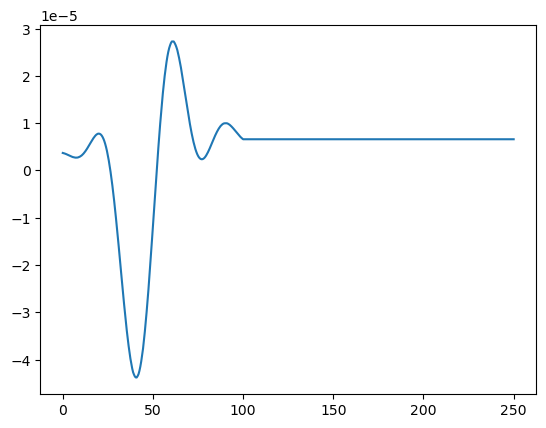

In [54]:
plt.plot(max_erg.index, np.array(max_erg['3']))

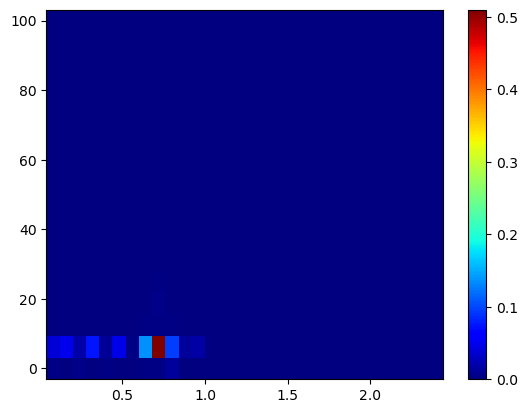

In [22]:
def compute_spectrogram(sig, nperseg, noverlap, window):
    time_step = 0.005
    sample_freq = 1 / time_step
    sig = np.array(max_erg[sig])
    freqs, times, Sxx = signal.spectrogram(sig, fs = sample_freq, nperseg = nperseg, noverlap = noverlap, window = window)
    
    return freqs, times, Sxx

freqs, times, Sxx = compute_spectrogram('132', nperseg = 32, noverlap = 16, window = 'tukey')

plt.pcolormesh(times, freqs, Sxx, cmap = 'jet')
plt.colorbar()

In [23]:
def get_features(sig, nperseg, noverlap, window):
    freqs, times, Sxx = compute_spectrogram(sig, nperseg, noverlap, window)
    num_t, num_f = Sxx.shape
    quadrant1 = Sxx[:num_t//2, :num_f//2]  # Top-left quadrant
    quadrant2 = Sxx[:num_t//2, num_f//2:]  # Top-right quadrant
    quadrant3 = Sxx[num_t//2:, :num_f//2]  # Bottom-left quadrant
    quadrant4 = Sxx[num_t//2:, num_f//2:]  # Bottom-right quadrant
#     print(f"q1: {quadrant1}, q2: {quadrant2}, q3: {quadrant3}, q4: {quadrant4}")

    
    q1spectrum = quadrant1.flatten()
    q2spectrum = quadrant2.flatten()
    q3spectrum = quadrant3.flatten()
    q4spectrum = quadrant4.flatten()
#     print(f"q1s: {q1spectrum}, q2s: {q2spectrum}, q3s: {q3spectrum}, q4s: {q4spectrum}")

#     if len(q1spectrum) == 0:
#         print(f"empty array at {sig}, {q1spectrum}, {quadrant1}")
#         return

    q1bmin = np.min(q1spectrum)
    q1bmedian = np.median(q1spectrum)
    q1bmax = np.max(q1spectrum)
    q1bmean = np.mean(q1spectrum)
    
    q2bmin = np.min(q2spectrum)
    q2bmedian = np.median(q2spectrum)
    q2bmax = np.max(q2spectrum)
    q2bmean = np.mean(q2spectrum)
    
    q3bmin = np.min(q3spectrum)
    q3bmedian = np.median(q3spectrum)
    q3bmax = np.max(q3spectrum)
    q3bmean = np.mean(q3spectrum)
    
    q4bmin = np.min(q4spectrum)
    q4bmedian = np.median(q4spectrum)
    q4bmax = np.max(q4spectrum)
    q4bmean = np.mean(q4spectrum)
    
    return q1bmin, q1bmedian, q1bmax, q1bmean, q2bmin, q2bmedian, q2bmax, q2bmean, q3bmin, q3bmedian, q3bmax, q3bmean, q4bmin, q4bmedian, q4bmax, q4bmean

In [24]:
# get_features('17.1', 32, 16, 'tukey')

In [25]:
# def get_parameters():
#     size, overlap, name = None, None, None
#     for n in NFFTS:
#         size = n
#     for o in overlaps:
#         overlap = o
#     for w in windows:
#         name = w
#     # use random.choice instead of loop
#     # then loop through the signals instead
#     return size, overlap, name

# print(get_parameters())

In [26]:
import random
def get_parameters():
    window_type = random.choice(windows)
    
    window_size = random.choice(NFFTS)

    overlap = random.choice(overlaps)
    
    while overlap >= window_size:
        overlap = random.choice(overlaps)

#     if overlap >= window_size:
#         window_size = random.choice(NFFTS)
#         overlap = random.choice(overlaps)
#     else:
#         return window_size, overlap, window_type
#         print(window_size, overlap, window_type)


    
    return window_size, overlap, window_type

#     print(window_size, overlap, window_type)
    
# get_parameters()

In [27]:
dfeatures = pd.DataFrame(columns = ['params', 'q1bmin', 'q1bmedian', 'q1bmax', 'q1bmean', 'q2bmin', 'q2bmedian', 'q2bmax', 'q2bmean', 'q3bmin', 'q3bmedian', 'q3bmax', 'q3bmean', 'q4bmin', 'q4bmedian', 'q4bmax', 'q4bmean', 'pat_no'])
dfeatures

,params,q1bmin,q1bmedian,q1bmax,q1bmean,q2bmin,q2bmedian,q2bmax,q2bmean,q3bmin,q3bmedian,q3bmax,q3bmean,q4bmin,q4bmedian,q4bmax,q4bmean,pat_no


In [28]:
diagdata.iloc[0]

3         healthy
5       unhealthy
6       unhealthy
6.1     unhealthy
6.2     unhealthy
15        healthy
17        healthy
17.1      healthy
Name: 0, dtype: object

In [29]:
for _ in range(len(data.columns)):
    window_size, overlap, window_type = get_parameters()
    for col in data.columns:
        
        q1bmin, q1bmedian, q1bmax, q1bmean, q2bmin, q2bmedian, q2bmax, q2bmean, q3bmin, q3bmedian, q3bmax, q3bmean, q4bmin, q4bmedian, q4bmax, q4bmean = get_features(str(col), window_size, overlap, window_type)
        
        new_dict = {'params': f'{window_type}{window_size}{overlap}', 'q1bmin': q1bmin, 'q1bmedian': q1bmedian, 'q1bmax': q1bmax, 'q1bmean': q1bmax, 'q2bmin': q2bmin, 'q2bmedian': q2bmedian, 'q2bmax': q2bmax, 'q2bmean': q2bmax, 'q3bmin': q3bmin, 'q3bmedian': q3bmedian, 'q3bmax': q3bmax, 'q3bmean': q3bmax, 'q4bmin': q4bmin, 'q4bmedian': q4bmedian, 'q4bmax': q4bmax, 'q4bmean': q4bmax, 'pat_no': col}
        new_features = pd.DataFrame(data = new_dict, index = range(0, len(new_dict)))
        dfeatures = pd.concat([dfeatures, new_features], ignore_index = True)

In [30]:
# new_features_list = []
# for col in data.columns:
#     print(col)
#     window_size, overlap, window_type = get_parameters()
#     bmin, bmedian, bmax, bmean = get_features(str(col), window_size, overlap, window_type)
#     new_dict = {'params': f'{window_type}{window_size}{overlap}', 'bmin': bmin, 'bmedian': bmedian, 'bmax': bmax, 'bmean': bmean, 'pat_no': col}
#     new_features = pd.DataFrame(data = new_dict, index = range(0, len(new_dict)))
#     new_features_list.append(new_features)
# dfeatures = pd.concat(new_features_list, ignore_index = True)
    
# # dfeatures

In [31]:
# transposed_diagdata = diagdata.T
# transposed_diagdata.index.name = 'pat_no'
# transposed_diagdata.columns = ['targets']
# transposed_diagdata

In [32]:
T_diagnoses = diag_max_erg.T
T_diagnoses.index.name = 'pat_no'
T_diagnoses.columns = ['targets']
T_diagnoses

,targets
pat_no,
3,unhealthy
3.1,healthy
5,unhealthy
6,unhealthy
6.1,unhealthy
...,...
1962.1,unhealthy
1963,unhealthy
1963.1,unhealthy


In [33]:
dfeatures = dfeatures.merge(T_diagnoses, on = 'pat_no', how = 'left')

In [34]:
dfeatures.drop_duplicates().head(30)

,params,q1bmin,q1bmedian,q1bmax,q1bmean,q2bmin,q2bmedian,q2bmax,q2bmean,q3bmin,q3bmedian,q3bmax,q3bmean,q4bmin,q4bmedian,q4bmax,q4bmean,pat_no,targets
0,tukey164,0.0,4.828034e-15,5.948878e-12,5.948878e-12,0.0,0.0,0.0,0.0,0.0,7.607071e-18,3.939962e-14,3.939962e-14,0.0,0.0,0.0,0.0,3,unhealthy
18,tukey164,0.0,6.526442e-15,3.155433e-12,3.155433e-12,0.0,0.0,0.0,0.0,0.0,6.648235e-18,2.062451e-14,2.062451e-14,0.0,0.0,0.0,0.0,5,unhealthy
36,tukey164,0.0,1.528292e-02,3.800268e+01,3.800268e+01,0.0,0.0,0.0,0.0,0.0,1.549109e-05,2.554580e-01,2.554580e-01,0.0,0.0,0.0,0.0,6,unhealthy
54,tukey164,0.0,4.536299e-15,5.941839e-12,5.941839e-12,0.0,0.0,0.0,0.0,0.0,7.985380e-18,4.009759e-14,4.009759e-14,0.0,0.0,0.0,0.0,6.1,unhealthy
72,tukey164,0.0,6.835920e-15,8.681906e-12,8.681906e-12,0.0,0.0,0.0,0.0,0.0,1.289585e-17,5.808962e-14,5.808962e-14,0.0,0.0,0.0,0.0,6.2,unhealthy
90,tukey164,0.0,1.038074e-02,1.166807e+01,1.166807e+01,0.0,0.0,0.0,0.0,0.0,9.330843e-06,7.900372e-02,7.900372e-02,0.0,0.0,0.0,0.0,15,healthy
108,tukey164,0.0,5.774380e-15,3.781152e-12,3.781152e-12,0.0,0.0,0.0,0.0,0.0,1.077632e-17,2.509684e-14,2.509684e-14,0.0,0.0,0.0,0.0,17,healthy
126,tukey164,0.0,5.611605e-15,3.971878e-12,3.971878e-12,0.0,0.0,0.0,0.0,0.0,1.222592e-17,2.727524e-14,2.727524e-14,0.0,0.0,0.0,0.0,17.1,healthy
144,hann164,0.0,2.938726e-15,2.916468e-12,2.916468e-12,0.0,0.0,0.0,0.0,0.0,2.114879e-18,1.175868e-15,1.175868e-15,0.0,0.0,0.0,0.0,3,unhealthy
162,hann164,0.0,4.233475e-15,1.582182e-12,1.582182e-12,0.0,0.0,0.0,0.0,0.0,1.939405e-18,5.874209e-16,5.874209e-16,0.0,0.0,0.0,0.0,5,unhealthy


In [35]:
targets = dfeatures.drop_duplicates().reset_index(drop = True)['targets']
targets

0     unhealthy
1     unhealthy
2     unhealthy
3     unhealthy
4     unhealthy
        ...    
59    unhealthy
60    unhealthy
61      healthy
62      healthy
63      healthy
Name: targets, Length: 64, dtype: object

In [36]:
sampled_features = dfeatures.drop_duplicates().drop(['pat_no', 'targets'], axis = 1).reset_index(drop = True)

In [37]:
sampled_features

,params,q1bmin,q1bmedian,q1bmax,q1bmean,q2bmin,q2bmedian,q2bmax,q2bmean,q3bmin,q3bmedian,q3bmax,q3bmean,q4bmin,q4bmedian,q4bmax,q4bmean
0,tukey164,0.0,4.828034e-15,5.948878e-12,5.948878e-12,0.0,0.0,0.0,0.0,0.0,7.607071e-18,3.939962e-14,3.939962e-14,0.0,0.0,0.0,0.0
1,tukey164,0.0,6.526442e-15,3.155433e-12,3.155433e-12,0.0,0.0,0.0,0.0,0.0,6.648235e-18,2.062451e-14,2.062451e-14,0.0,0.0,0.0,0.0
2,tukey164,0.0,1.528292e-02,3.800268e+01,3.800268e+01,0.0,0.0,0.0,0.0,0.0,1.549109e-05,2.554580e-01,2.554580e-01,0.0,0.0,0.0,0.0
3,tukey164,0.0,4.536299e-15,5.941839e-12,5.941839e-12,0.0,0.0,0.0,0.0,0.0,7.985380e-18,4.009759e-14,4.009759e-14,0.0,0.0,0.0,0.0
4,tukey164,0.0,6.835920e-15,8.681906e-12,8.681906e-12,0.0,0.0,0.0,0.0,0.0,1.289585e-17,5.808962e-14,5.808962e-14,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,blackmanharris84,0.0,1.579448e-15,2.028435e-13,2.028435e-13,0.0,0.0,0.0,0.0,0.0,1.713247e-17,7.141734e-14,7.141734e-14,0.0,0.0,0.0,0.0
60,blackmanharris84,0.0,2.667903e-15,3.091573e-13,3.091573e-13,0.0,0.0,0.0,0.0,0.0,2.030141e-17,1.083559e-13,1.083559e-13,0.0,0.0,0.0,0.0
61,blackmanharris84,0.0,4.048870e-03,3.645723e-01,3.645723e-01,0.0,0.0,0.0,0.0,0.0,2.624356e-05,1.288841e-01,1.288841e-01,0.0,0.0,0.0,0.0
62,blackmanharris84,0.0,2.107075e-15,1.104004e-13,1.104004e-13,0.0,0.0,0.0,0.0,0.0,1.949897e-17,3.847871e-14,3.847871e-14,0.0,0.0,0.0,0.0


In Scikit-learn, it noted that the current DT implementation doesn't work with categorical variables. then what does that mean for my `params` variables

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [39]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.0 MB/s eta 0:00:00


In [40]:
from dtreeviz.trees import *

In [64]:
import dtreeviz

### Label Encoding of Targets

In [41]:
label = LabelEncoder()
label.fit(targets)
label.classes_

array(['healthy', 'unhealthy'], dtype=object)

In [42]:
encoded_targets = label.transform(targets)
encoded_targets

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [43]:
len(encoded_targets)

64

In [44]:
sampled_features_encoded = pd.get_dummies(sampled_features, sparse = True, columns = ['params'])

In [45]:
sampled_features_encoded

,q1bmin,q1bmedian,q1bmax,q1bmean,q2bmin,q2bmedian,q2bmax,q2bmean,q3bmin,q3bmedian,...,q4bmax,q4bmean,params_blackmanharris1284,params_blackmanharris84,params_boxcar164,params_hamming1282,params_hamming162,params_hann162,params_hann164,params_tukey164
0,0.0,4.828034e-15,5.948878e-12,5.948878e-12,0.0,0.0,0.0,0.0,0.0,7.607071e-18,...,0.0,0.0,0,0,0,0,0,0,0,1
1,0.0,6.526442e-15,3.155433e-12,3.155433e-12,0.0,0.0,0.0,0.0,0.0,6.648235e-18,...,0.0,0.0,0,0,0,0,0,0,0,1
2,0.0,1.528292e-02,3.800268e+01,3.800268e+01,0.0,0.0,0.0,0.0,0.0,1.549109e-05,...,0.0,0.0,0,0,0,0,0,0,0,1
3,0.0,4.536299e-15,5.941839e-12,5.941839e-12,0.0,0.0,0.0,0.0,0.0,7.985380e-18,...,0.0,0.0,0,0,0,0,0,0,0,1
4,0.0,6.835920e-15,8.681906e-12,8.681906e-12,0.0,0.0,0.0,0.0,0.0,1.289585e-17,...,0.0,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.0,1.579448e-15,2.028435e-13,2.028435e-13,0.0,0.0,0.0,0.0,0.0,1.713247e-17,...,0.0,0.0,0,1,0,0,0,0,0,0
60,0.0,2.667903e-15,3.091573e-13,3.091573e-13,0.0,0.0,0.0,0.0,0.0,2.030141e-17,...,0.0,0.0,0,1,0,0,0,0,0,0
61,0.0,4.048870e-03,3.645723e-01,3.645723e-01,0.0,0.0,0.0,0.0,0.0,2.624356e-05,...,0.0,0.0,0,1,0,0,0,0,0,0
62,0.0,2.107075e-15,1.104004e-13,1.104004e-13,0.0,0.0,0.0,0.0,0.0,1.949897e-17,...,0.0,0.0,0,1,0,0,0,0,0,0


In [55]:
feature_names = sampled_features_encoded.columns
feature_names

Index(['q1bmin', 'q1bmedian', 'q1bmax', 'q1bmean', 'q2bmin', 'q2bmedian',
       'q2bmax', 'q2bmean', 'q3bmin', 'q3bmedian', 'q3bmax', 'q3bmean',
       'q4bmin', 'q4bmedian', 'q4bmax', 'q4bmean', 'params_blackmanharris1284',
       'params_blackmanharris84', 'params_boxcar164', 'params_hamming1282',
       'params_hamming162', 'params_hann162', 'params_hann164',
       'params_tukey164'],
      dtype='object')

### Data Splitting

In [46]:
random_state = 42
X_train, X_val, y_train, y_val = train_test_split(sampled_features_encoded, encoded_targets, test_size = 0.4, random_state = random_state, stratify = targets)

In [47]:
# ohencoder = OneHotEncoder(sparse_output = True, handle_unknown = 'ignore')
# params_encoded = ohencoder.fit_transform(X_train[['params']])

In [48]:
# ohencoder.categories_

In [49]:
# params_encoded

In [50]:
# encoded_params = pd.
# encoded_params

In [51]:
def cross_validation (X, y, model, scoring, cv_rule):
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Cross-Validation error')
    DF_poly = pd.DataFrame(scores)
    display(DF_poly)
    print('\n')
    print(DF_poly.mean()[2:])

In [52]:
max_depth = 7
min_samples_split = 15
max_leaf_nodes = 15

In [53]:
DT_clf = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, max_leaf_nodes = max_leaf_nodes)
DT_clf.fit(X_train, y_train)
scoring = {"ACC": 'accuracy'}
cross_validation(sampled_features_encoded, targets, DT_clf, scoring, StratifiedKFold(n_splits = 5))
y_predict = DT_clf.predict(X_val)
print('test error')
print('ACC: %.4f' % acc(y_predict, y_val))
print('F1: %.4f' % f1(y_predict, y_val, average = 'micro'))
print(classification_report(y_val, y_predict, target_names = label.classes_))

Cross-Validation error


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.I

,fit_time,score_time,test_ACC
0,0.005917,0.003713,0.615385
1,0.005296,0.002713,0.615385
2,0.005320,0.002617,0.538462
3,0.005166,0.002549,0.615385
4,0.005015,0.002560,0.666667




test_ACC    0.610256
dtype: float64
test error
ACC: 0.4615
F1: 0.4615
              precision    recall  f1-score   support

     healthy       0.17      0.10      0.12        10
   unhealthy       0.55      0.69      0.61        16

    accuracy                           0.46        26
   macro avg       0.36      0.39      0.37        26
weighted avg       0.40      0.46      0.42        26



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


[Text(0.7142857142857143, 0.9, 'q1bmedian <= 0.0\ngini = 0.465\nsamples = 38\nvalue = [14, 24]\nclass = unhealthy'),
 Text(0.5714285714285714, 0.7, 'params_blackmanharris1284 <= 0.5\ngini = 0.384\nsamples = 27\nvalue = [7, 20]\nclass = unhealthy'),
 Text(0.42857142857142855, 0.5, 'params_blackmanharris84 <= 0.5\ngini = 0.434\nsamples = 22\nvalue = [7, 15]\nclass = unhealthy'),
 Text(0.2857142857142857, 0.3, 'params_tukey164 <= 0.5\ngini = 0.475\nsamples = 18\nvalue = [7, 11]\nclass = unhealthy'),
 Text(0.14285714285714285, 0.1, 'gini = 0.459\nsamples = 14\nvalue = [5, 9]\nclass = unhealthy'),
 Text(0.42857142857142855, 0.1, 'gini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = healthy'),
 Text(0.5714285714285714, 0.3, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = unhealthy'),
 Text(0.7142857142857143, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]\nclass = unhealthy'),
 Text(0.8571428571428571, 0.7, 'gini = 0.463\nsamples = 11\nvalue = [7, 4]\nclass = healthy')]

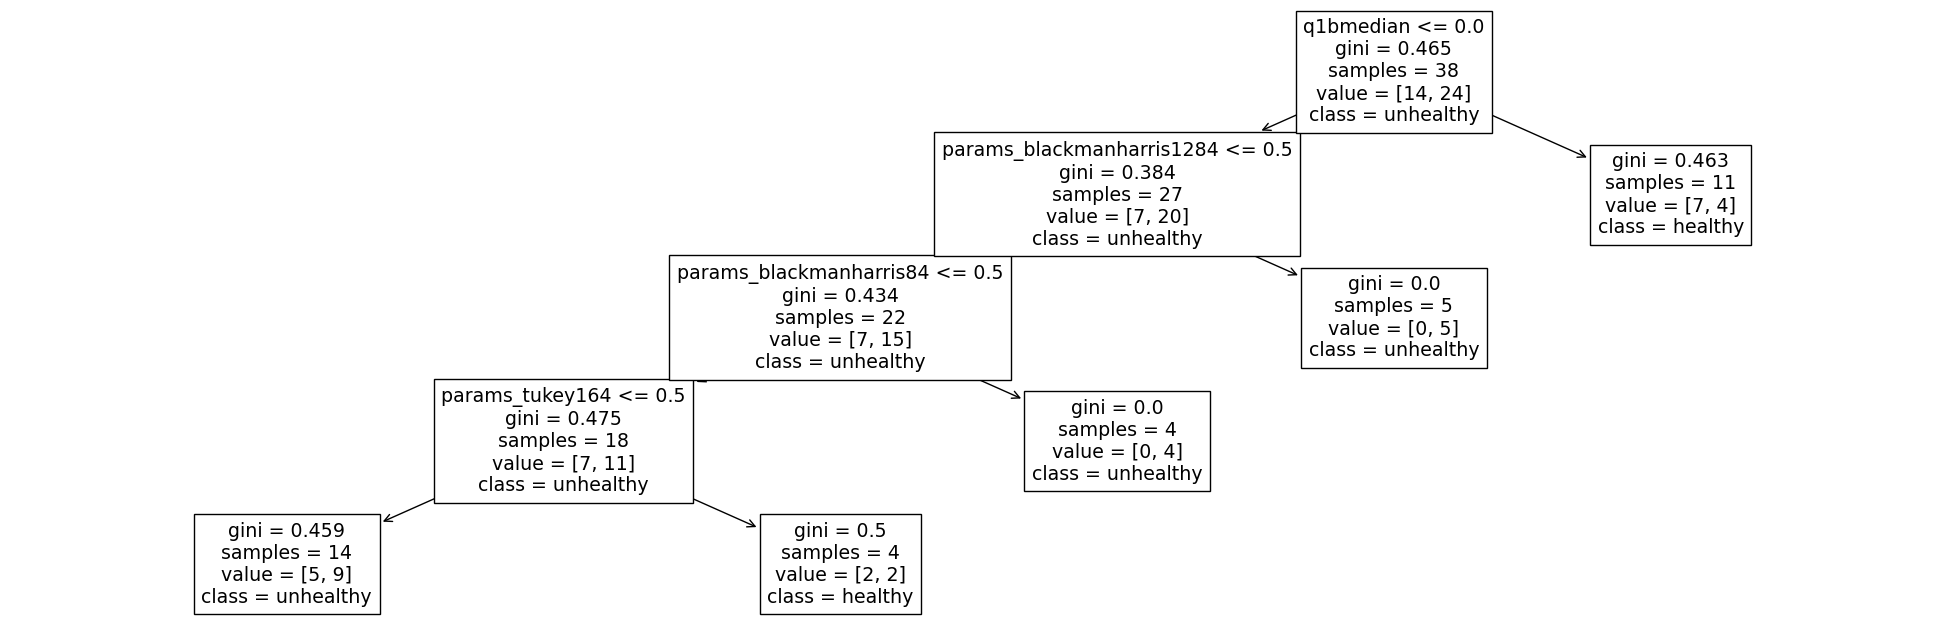

In [56]:
plt.figure(figsize = (25, 8))
tree.plot_tree(DT_clf, feature_names = feature_names, class_names = label.classes_)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


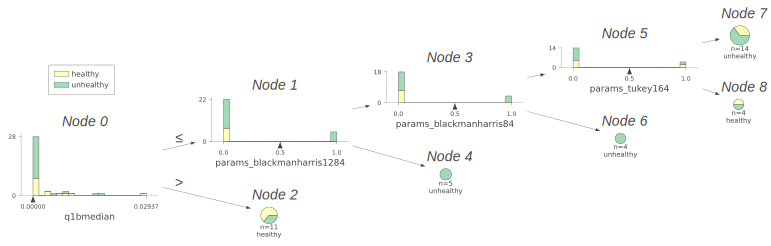

In [74]:
viz = dtreeviz.model(DT_clf,
               X_train, y_train,
               feature_names=feature_names,
               class_names=list(label.classes_),
#                orientation='LR',
#                show_node_labels = True,
#                colors={'classes':((),   # 0 classes
#                                   (),   # 1 class
#                                   (),   # 2 classes
#                                   ('#ff0000','#00ff00','#0000ff') # 3 classes
#                                   )},
               )
              
viz.view(orientation = 'LR',
        show_node_labels = True)

In [75]:
DT_clf.feature_importances_

array([0.        , 0.53375154, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19807186, 0.23768623, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03049036])

InvalidIndexError: (slice(None, None, None), 2)

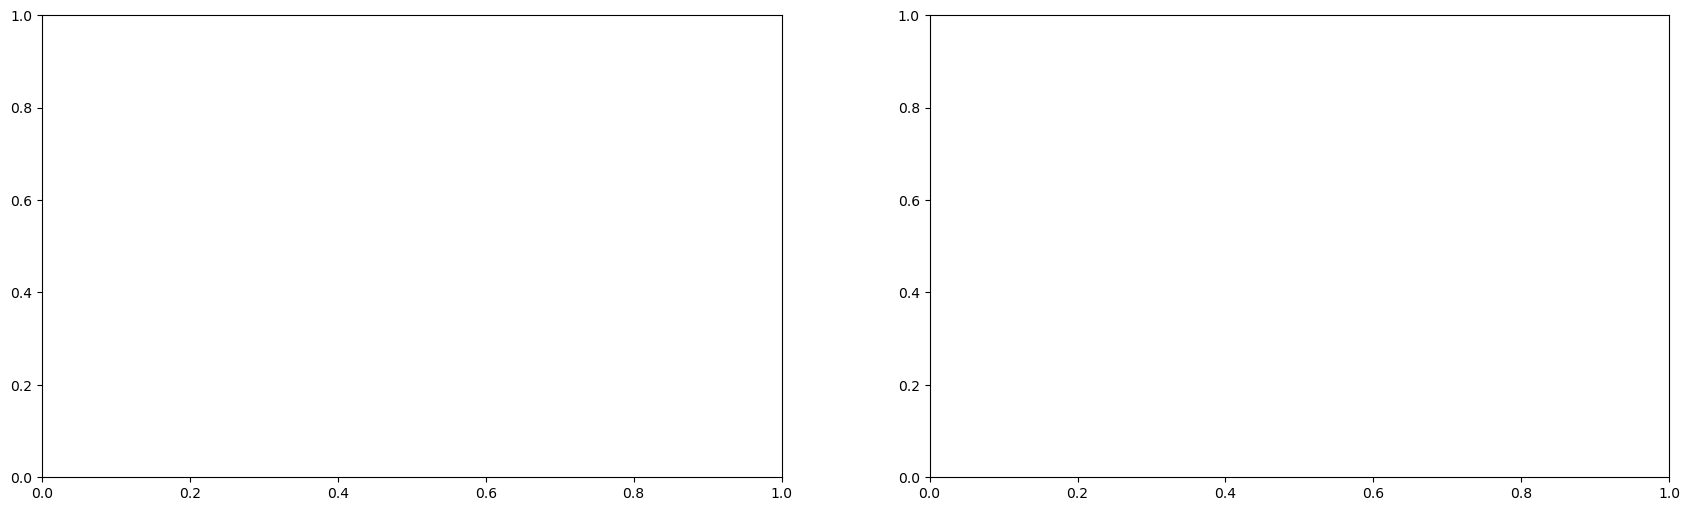

In [77]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[21, 6])

colors = ['orangered',  'lawngreen', 'purple']
ax1.plot(sampled_features_encoded[:, 2][targets == 0], sampled_features_encoded[:, 3][targets == 0], "o", color=colors[0])
ax1.plot(sampled_features_encoded[:, 2][targets == 1], sampled_features_encoded[:, 3][targets == 1], "^", color=colors[1])
ax1.plot(sampled_features_encoded[:, 2][targets == 2], sampled_features_encoded[:, 3][targets == 2], "d", color=colors[2])
ax1.set_xlabel(feature_names[2])
ax1.set_ylabel(feature_names[3])

artists = tree.plot_tree(DT_clf, feature_names=feature_names, class_names=labels.classes_,
                         filled=True, rounded=True, ax=ax2)

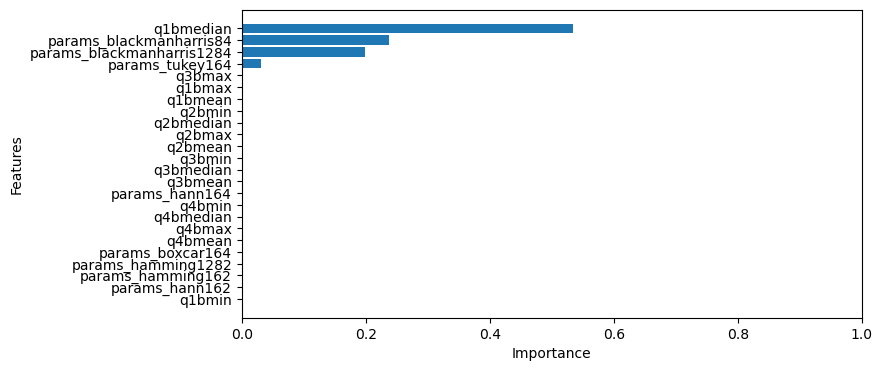

In [78]:
feature_importance = DT_clf.feature_importances_
features_names = np.array(feature_names)
sorted = np.argsort(feature_importance)

ypos = np.arange(len(features_names))

fig= plt.figure(figsize=(8,4))
plt.barh(ypos, feature_importance[sorted])
plt.xlim([0,1])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.yticks(ypos,features_names[sorted] );

### GridSearch Hyperparameter optimization

In [79]:
X = sampled_features_encoded.values
y = targets

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4,stratify = y, random_state=42)

In [80]:
DT_clf = DecisionTreeClassifier()
path = DT_clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

tuned_parameters = {'ccp_alpha': ccp_alphas[:-1]}



DT_clf_search = GridSearchCV(estimator = DT_clf,
                          param_grid=tuned_parameters ,
                          cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42),
                          verbose=2)


DT_clf_search.fit(X_train, y_train)

DT_clf_best=DT_clf_search.best_estimator_

DT_clf_best.fit(X_train, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END .....................ccp_alpha=0.003401360544217691; total time=   0.0s
[CV] END .....................ccp_alpha=0.0034013

In [81]:
scoring = {'ACC': 'accuracy',}


cross_validation (X, y, DT_clf_best, 
                  scoring, StratifiedKFold(n_splits=5)) 

Cross-Validation error


,fit_time,score_time,test_ACC
0,0.003021,0.002030,0.769231
1,0.002581,0.001209,0.615385
2,0.001834,0.000956,0.615385
3,0.001372,0.000818,0.615385
4,0.001298,0.000897,0.666667




test_ACC    0.65641
dtype: float64


In [82]:
DT_clf_best.fit(X_train, y_train)

y_predict=DT_clf_best.predict(X_test)

print('test error')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='micro'))
print('F1 : %.4f' %  f1(y_predict,y_test,average='macro'))
print (classification_report(y_test, y_predict, target_names=label.classes_))

test error
ACC: 0.6154
F1 : 0.6154
F1 : 0.4583
              precision    recall  f1-score   support

     healthy       0.50      0.10      0.17        10
   unhealthy       0.62      0.94      0.75        16

    accuracy                           0.62        26
   macro avg       0.56      0.52      0.46        26
weighted avg       0.58      0.62      0.53        26



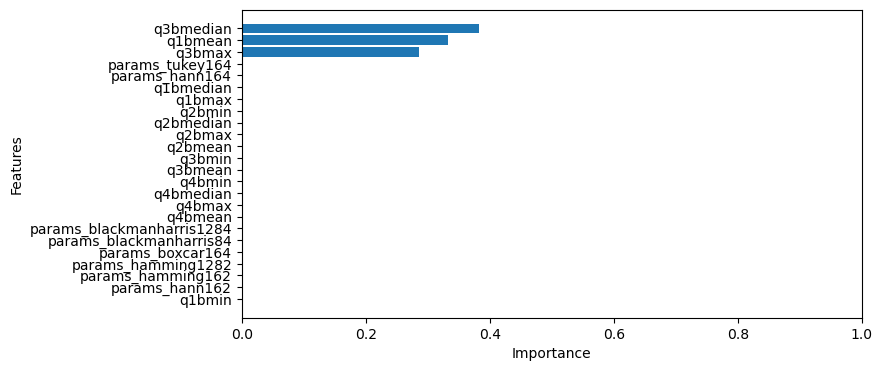

In [83]:
feature_importance = DT_clf_best.feature_importances_
features_names = np.array(feature_names)
sorted = np.argsort(feature_importance)

ypos = np.arange(len(features_names))

fig= plt.figure(figsize=(8,4))
plt.barh(ypos, feature_importance[sorted])
plt.xlim([0,1])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.yticks(ypos,features_names[sorted] );

In [84]:
value = np.random.randint(0, len(X_test))

x = X_test[value,:]

print('True Value')
print(label.classes_[y_test[value]])

viz = dtreeviz.model(DT_clf_best,
               X_train, y_train,
               X = x,
               feature_names=feature_names,
               class_names=list(label.classes_),
#                orientation='LR',
#                show_node_labels = True,
#                colors={'classes':((),   # 0 classes
#                                   (),   # 1 class
#                                   (),   # 2 classes
#                                   ('#ff0000','#00ff00','#0000ff') # 3 classes
#                                   )},
               )
              
viz.view(orientation = 'LR',
        show_node_labels = True)

True Value


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices